In [59]:
import numpy as np
import pandas as pd
import tensorflow as tf
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt
import requests
import time

In [60]:
model = None
try:
    # Path to the SavedModel directory
    saved_model_path = "models/model"
    # Load the model
    model = tf.keras.models.load_model(saved_model_path)
except:
    # Mac has to run on python 3.9 as mac M1 is silly, so need to load model with legacy format
    model = tf.keras.models.load_model("../models/lstm_eth_model.h5")

In [61]:
#Read test data
df = pd.read_csv('prices.log', header=None, names=["Price", "Timestamp"])
prices = np.array(df['Price']).reshape(-1, 1)

In [62]:
#Set min-max scaler to same as model
model_data = pd.read_csv('../model_data.csv')
real_prices = np.array(model_data['price'])

# Load the same MinMaxScaler used during training
scaler = MinMaxScaler(feature_range=(0, 1))
scaler.fit(real_prices.reshape(-1, 1))  # Fit on the current live prices

MinMaxScaler()

In [63]:
# Scale prices to match training format
scaled_prices = scaler.transform(prices)
scaled_prices = scaled_prices
# Prepare the data for LSTM (same sequence length used in training)
sequence_length = 10  # Adjust based on your model
X_test = []
last_price = []

for i in range(0, len(scaled_prices) - sequence_length, sequence_length):
    X_test.append(scaled_prices[i : i + sequence_length])
    last_price.append(prices[i + sequence_length])

X_test = np.array(X_test)

# Make predictions
predictions = model.predict(X_test)

# Inverse transform the predictions to get actual price values
predicted_prices = scaler.inverse_transform(predictions)

9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step


In [64]:
#pull real prices to compare with predictions
prices_to_compare = []
step_length = 5
for i in range(sequence_length + step_length - 1, len(prices), sequence_length):
    prices_to_compare.append(prices[i])

len(prices_to_compare)

274

In [65]:
def print_percent_diff(A, B):
    # Compute % difference for each element
    percent_diff = np.abs(A - B) / ((A + B) / 2) * 100

    # Compute and print the average percentage difference
    average_percent_diff = np.mean(percent_diff)
    print("Average Percentage Difference:", average_percent_diff)

In [66]:
print_percent_diff(predicted_prices, prices_to_compare)

Average Percentage Difference: 0.13691533665752229


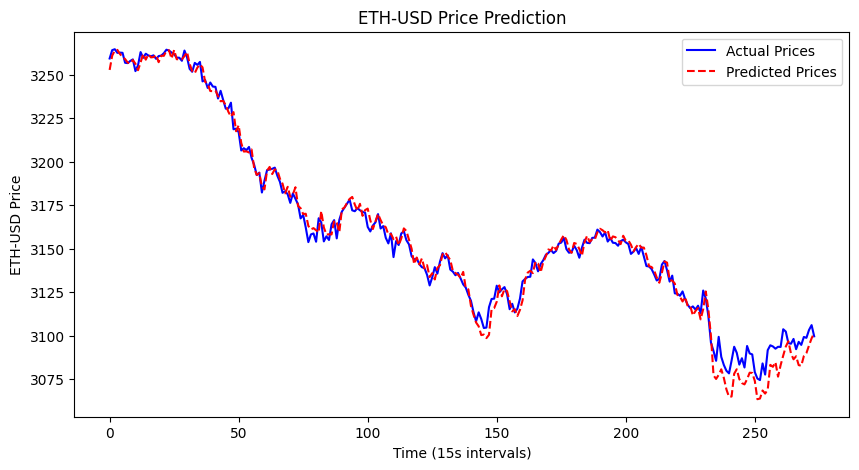

In [67]:
# Plot the results
plt.figure(figsize=(10, 5))
plt.plot(prices_to_compare, label="Actual Prices", color="blue")
plt.plot(predicted_prices, label="Predicted Prices", color="red", linestyle="dashed")
plt.xlabel("Time (15s intervals)")
plt.ylabel("ETH-USD Price")
plt.legend()
plt.title("ETH-USD Price Prediction")
plt.show()

In [68]:
correct_buy_predictions = 0
incorrect_buy_predictions = 0
correct_sell_predictions = 0
incorrect_sell_predictions = 0

for i in range(len(predicted_prices)):
    # Real price of ETH
    real_price = prices_to_compare[i]
    #Predicted price of ETH
    predicted_price = predicted_prices[i]
    #Price 5 timestamps ago
    previous_price = last_price[i]

    #Check if both prediction and real price were up or down
    if (real_price - previous_price > 0 and predicted_price - previous_price > 0):
        correct_buy_predictions += 1
    elif( real_price - previous_price < 0 and predicted_price - previous_price > 0):
        incorrect_buy_predictions += 1
    elif (real_price - previous_price < 0 and predicted_price - previous_price < 0):
        correct_sell_predictions += 1
    elif (real_price - previous_price > 0 and predicted_price - previous_price < 0):
        incorrect_sell_predictions += 1

print(f"SELL Predictions: {correct_sell_predictions + incorrect_sell_predictions} Correct: {correct_sell_predictions} Incorrect: {incorrect_sell_predictions} Correct Rate: {(correct_sell_predictions/(correct_sell_predictions + incorrect_sell_predictions) * 100)}%")
print(f"BUY Predictions: {correct_buy_predictions + incorrect_buy_predictions} Correct: {correct_buy_predictions} Incorrect: {incorrect_buy_predictions} Correct Rate: {(correct_buy_predictions/(correct_buy_predictions + incorrect_buy_predictions) * 100)}%")
total_correct = correct_buy_predictions + correct_sell_predictions
total_incorrect = incorrect_buy_predictions + incorrect_sell_predictions
print(f"Overall correct rate: {(total_correct/len(predicted_prices))*100}%")


SELL Predictions: 133 Correct: 87 Incorrect: 46 Correct Rate: 65.41353383458647%
BUY Predictions: 141 Correct: 100 Incorrect: 41 Correct Rate: 70.92198581560284%
Overall correct rate: 68.24817518248175%
